# Optimization, Optax and Haiku



<a href="https://colab.research.google.com/github/khipu-ai/practicals-2023/blob/main/notebooks/optimization_and_haiku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Copyright

© Deep Learning Indaba 2022. Apache License 2.0.
© Khipu 2023. Apache License 2.0.

## Authors

* Kale-ab Tessera (Indaba 2022)
* Ignacio Ramírez (Khipu 2023)

## Reviewers
* Javier Antoran
* James Allingham
* Ruan van der Merwe
* Sebastian Bodenstein
* Laurence Midgley
* Joao Guilherme
* Elan van Biljon


# Introduction

The three topics introduced in this practical aim at providing you with the tools to train your models. We will begin with the basic concepts of **numerical optimization**, in particular cost function minimization, which is the main method whereby we learn models.

We will then show you how to use the [Optax](https://github.com/deepmind/optax) library, an efficient optimization library based on JAX.

Finally, we'll visit [Haiku](https://github.com/deepmind/dm-haiku), a library for building and training neural networks.

## Prerequisites

We will assume that you are familiar with Python, Numpy and JAX. If not, please check out our [Practical](http://no.link.yet).

## Requirements

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.



## Installation and Imports

In [1]:
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. (Run Cell)

import os

# https://stackoverflow.com/questions/68340858/in-google-colab-is-there-a-programing-way-to-check-which-runtime-like-gpu-or-tpu
if int(os.environ["COLAB_GPU"]) > 0:
    print("a GPU is connected.")
elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
    print("A TPU is connected.")
    import jax.tools.colab_tpu

    jax.tools.colab_tpu.setup_tpu()
else:
    print("Only CPU accelerator is connected.")
    # x8 cpu devices - number of (emulated) host devices
    os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap

import matplotlib.pyplot as plt
import numpy as np

a GPU is connected.


In [2]:
# @title Helper Functions. (Run Cell)
import copy
from typing import Dict


def plot_performance(data: Dict, title: str):
    runs = list(data.keys())
    time = list(data.values())

    # creating the bar plot
    plt.bar(runs, time, width=0.35)

    plt.xlabel("Implementation")
    plt.ylabel("Average time taken (in s)")
    plt.title(title)
    plt.show()

    best_perf_key = min(data, key=data.get)
    all_runs_key = copy.copy(runs)

    # all_runs_key_except_best
    all_runs_key.remove(best_perf_key)

    for k in all_runs_key:
        print(
            f"{best_perf_key} was {round((data[k]/data[best_perf_key]),2)} times faster than {k} !!!"
        )

In [3]:
# @title Check the device you are using (Run Cell)
print(f"Num devices: {jax.device_count()}")
print(f" Devices: {jax.devices()}")

Num devices: 1
 Devices: [GpuDevice(id=0, process_index=0)]


$$
\newcommand{\because}[1]{&& \triangleright \textrm{#1}}
$$

# Model learning and optimization

Machine learning is all about learning _models_. In this context, models are mathematical objects that synthesize our knowledge on data from some domain. This knowledge then allows us, for example, to infer the output or response of a system given a certain input (regression, classification), to synthesize new data samples (unsupervised learning, simmulations, generative models), or to take the optimal action in a certain context (reinforcement learning).

In any case, models are defined by a certain functional form which depends on a set of _parameters_ (this includes _non parametric_ models despite the name). Although the general form of a model may be known beforehand (e.g., a certain neural network architecture), its parameters are not, and depend on the data that we want to process.

The process of adjusting (learning) the parameters of a model is usually done by defining a  _cost function_ which tells us how good our model is for some data, and then tuning the parameters, automatically, to minimize the cost; this is done by means of _optimization algorithms_.

## Linear regression

$\def\reals{\mathbb{R}}$
$\def\tr{^\mathsf{T}}$
$\def\data{\mathcal{D}}$
$\def\opt{^{*}}$
$\def\loss{\ell}$
$\newcommand{\mat}[1]{\mathbf{#1}}$
$\newcommand{\vec}[1]{\mathbf{#1}}$
$\def\inv{^{-1}}$
A simple example to begin with is linear regression. Given an input vector $x\in\reals^n$ and an output $y\in\reals$, we assume that the input-output relationship is $y=w\tr x$ where $w\in\reals$ are parameters to be tuned. 
The following code generates data approximately following the above relation.




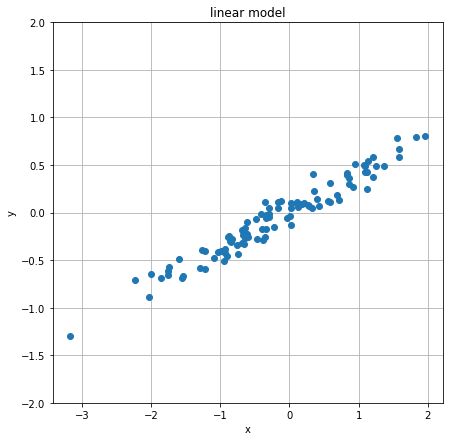

In [45]:
from numpy import random

rng = random.default_rng(2023)

def sim_linear_model(w,n):
  """
  given a linear coefficient w and a non-negative integer n
  generate n samples according to y = wx + v
  where v is a random Gaussian variable with mean 0
  and standard deviation 0.1
  """
  m = len(w)
  X = random.normal(size=(n))
  v = 0.1*random.normal(size=n)
  y = w*X + v
  return X,y

#
# our ground truth, w = 0.4
#
w = [0.4]
#
# simmulate samples
#
x,y = sim_linear_model(w,100)
#
# plot simmulated data
#
plt.figure(figsize=(7,7))
plt.plot(x,y,'o')
plt.title('linear model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.ylim(-2,2)
plt.show()

In general, we don't know $w$; what we have instead is data given as pairs $\data = \{(x_i,y_i):i=1,\ldots,n\}$ for which we assume that the above functional relationship holds, at least approximately. 

What we need to do is to find optimal values of $w\opt$ so that the relationship $y=w\tr x$ holds as best as possible, that is, we want $y-w\tr x \approx 0$ for every data pair. A natural way of doing so is to compute the accumulated squared approximation error $(y-w\tr x)^2$ for all the samples in the data. With this, we can now define our loss function $\ell(\data;w)$:

$$\ell(\data;w) = \sum_i (y_i - w\tr x_i)^2$$

For simplicity, we will drop the $\data$ and write $\loss(x)$ hereafter. However, remember that this is a function of $\data$ as well.  In the one-dimensional case above, we can actually plot $\loss(w)$. Let's try this for a range of values:



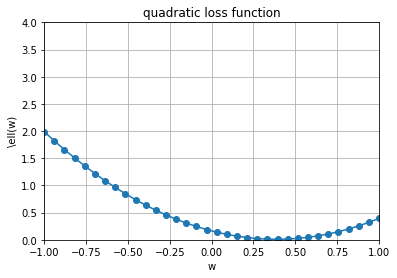

In [46]:
def quadratic_loss(x,y,w):
  """ 
  implements the above loss function for one dimensional inputs
  """
  return np.mean( (w*x-y)**2 ) # we divide by n to keep things small
#
# 100 parameter values between -3 and 3
#
ws = np.linspace(-3,3,100)
#
# very nice Python stuff: comprehensions
#
ls = [quadratic_loss(x,y,w) for w in ws]


plt.figure(figsize=(6,4))
plt.plot(ws,ls,'o-')
plt.title('quadratic loss function')
plt.xlabel('w')
plt.ylabel('\ell(w)')
plt.ylim(0,4)
plt.xlim(-1,1)
plt.grid(True)
plt.show()

So we see above that the function is a simple parabola. In $n$-dimensional problems, it is actually, always, a paraboloid. 

## Finding the optimal parameters

So how do we find $w\opt$? Well, as we can see, and as any paraboloid, $\loss(w)$ it is a convex function of $w$, which means that it there exists a parameters $w\opt$ so that the loss is minimal with respect to any other parameter values. In this case the function is strongly convex, which means that $w\opt$ is unique. 

Basic calculus tells us that, when a minima is attained, the derivative of $\ell(w)$ is $0$. For this case, we can find the optimal parameters right away by differentiating and solving for $w$:

$$\frac{d\ell}{dw}=-2 \sum_i (y_i - w\tr x_i)x_i\tr = 0\;\Rightarrow\sum_i y_ix_i\tr  - \sum_i w\tr x_ix_i\tr = 0$$

When we work with Machine Learning, and in optimization in general, it is convenient to express such relationships in a more compact way. This makes it more clear and, fundamentally, allows us to speed up computations. In our case, if we define $\mat{X}$ to be a matrix whose columns are $x_i$, and $\vec{y}$ a vector whose elements are $y_i$, we can write the above relationship as:

$$\vec{y}\mat{X}\tr - \vec{w}\mat{X}\mat{X}\tr = 0 \Rightarrow \vec{y}\mat{X}\tr =\vec{w}\mat{X}\mat{X}\tr.$$

We can now multiply both sides by $(\mat{X}\mat{X}\tr)\inv$ to obtain $\vec{w}\opt$ (provided that the inverse exists):

$$\vec{w} = \vec{y}\mat{X}\tr(\mat{X}\mat{X}\tr)\inv.$$

The above is known as the _least squares_ solution to the quadratic cost regression problem. Let's compute it:




In [47]:
w_ls =  np.sum(y*x)/np.dot(x,x)
print('true w:',w,'w found by least squares:',w_ls)

true w: [0.4] w found by least squares: 0.38829678571836745


### Comments

Notice that the  parameter _estimated_ by least squares is not the exact, true value $0.4$. Why might this be? 

In any case, it is quite close. 

## Gradient descent

So why bother with optimization algorithms? There are two main reasons:

1. The parameters $w\opt$ cannot be found by hand. **this happens most of the time**
1. In some cases, although the a closed form solution exists, it may be very hard to compute. Imagine for example that the dimension of the data samples is $n=1000000$; this might be a small $1000{\times}1000$ image. In most computers we will have a hard time inverting a $1000000{\times}1000000$ matrix!

When any of those occur, we need to find the solution in a different way. Optimization algorithms do so _iteratively_. 

There are brute force algorithms which try to find the solution by evaluating the cost function for many values of $w$, but this is impractical unless $n$ is very small, for example $1$. Sometimes, this is all you can do. However, if the cost function to be minimized is _differentiable_, there is a smarter way to look for solutions by following the _gradient_ of the function, but in the opposite direction.

The rationale behind this idea is simple: by definition, the gradient of the const function, $\nabla \loss(w)$, indicates  the direction along which the function _increases the most_. Thus, if we go the opposite direction, we can expect the function to _decrease the most_. Algorithms based on this idea are known as _descent methods_. Those that go in the exact opposite direction, $-\nabla \loss(w)$, are known as _gradient descent methods_.

Linear models with quadratic losses are excellent examples to begin exploring descent techniques because we can find the exact solution by hand and thus monitor our progress. We will now step up the problem a bit and work in two dimensions.

 

In [ ]:
def manual_grad(b, w):
    grad_b = 0
    grad_w = 0
    for x, y in zip(x_data_list, y_data_list):
        f = w * x + b
        grad_b += f - y
        grad_w += (f - y) * x
    grad_b /= len(x_data_list)
    grad_w /= len(x_data_list)
    return grad_b, grad_w

##### **Gradient Descent** 

Not that we have the gradients, we can use gradient descent. The general idea is to start with an initial value/guess for the model weights and then repeatedly use the gradients to tweak the parameters $\color{red}{b}$ and $\color{red}{w}$ in the right direction.  

These updates can be formulated as follows:

$$\color{red}{b} \leftarrow \color{red}{b} - \color{blue}{\eta} \frac{\partial \mathcal{L}}{\partial \color{red}{b}} $$ 

$$\color{red}{w} \leftarrow \color{red}{w} - \color{blue}{\eta} \frac{\partial \mathcal{L}}{\partial \color{red}{w}} $$ 

, where $\color{blue}{\eta}$ is the **learning rate** and just tells us how much we are going to scale the gradient before we use it to update our parameters:
are we going to try to walk downhill with big steps or small steps?

**Exercise 2.5**
1. Run the code snippet below, and note the $(\color{red}{b}, \color{red}{w})$ trajectory as we use the gradient to (try to) get to the minimum.
2. Adjust the starting values for $\color{red}{b}$ or $\color{red}{w}$ or the value of $\color{blue}{\eta}$ and see how the resulting trajectory to the minimum changes.
3. Can you find a setting for $\color{blue}{\eta}$ where things start spiraling out of control and the loss gets bigger and bigger (and not smaller)?
4. Can you find a setting for $\color{blue}{\eta}$ so that we're still far away from the minimum after `200` parameter update steps?
5. Play around with the `max_grad` variable. Do we always need this? What problem does this solve? (Hint: Trying printing the grads values with `max_grad = None`).



In [ ]:
b = 0  # Change me! Try 2, 4
w = -0.05  # Change me! Try -1, 2
learning_rate = 0.01  # Change me! Try 0.1, 0.5, ...
max_grad = 1  # Change me! Try None, 10

parameters_step_list = []

for _ in range(200):
    parameters_step_list.append([b, w])
    grad_b, grad_w = manual_grad(b, w)
    # Naive gradient value clipping - different from standard gradient clipping - which clips the gradient norm.
    if max_grad:
        grad_b = jnp.clip(grad_b, a_min=-max_grad, a_max=max_grad)
        grad_w = jnp.clip(grad_w, a_min=-max_grad, a_max=max_grad)
    b = b - learning_rate * grad_b
    w = w - learning_rate * grad_w

plot_loss(
    parameters_step_list, "A loss function, and minimizing it with gradient descent"
)

##### **Autodiff using JAX: No more manual gradients!**

In the above example, we calculated the gradients by hand (`manual_grad`). Thanks to automatic differentiation, we don't have to do this! While you can probably derive and code the gradients of the loss function for our linear model without making a mistake somewhere, getting the gradients right for more complex models can be much more work. Much, much more work! 

We use JAX to do the automatic differentiation, using the `grad` function as follows:
```
auto_grad = jax.grad(loss_function, argnums=(0, 1))
```

and call it in the same way as we called `manual_grad`. `argnums` tells JAX we want the partial derivative of our function with respect to the first 2 parameters.

In [ ]:
x = np.array(x_data_list)
y = np.array(y_data_list)


def loss_function(b, w):
    f = w * x + b
    errors = jnp.square(y - f)
    # Instead of summing over individual data points in a for-loop, and then
    # dividing to get the average, we do it in one go. No more for-loops!
    return 1 / 2 * jnp.mean(errors)


# This is it! One line of code.
auto_grad = jax.grad(loss_function, argnums=(0, 1))

# Let's see if it works. Does auto_grad match our manual version?
b, w = 2.5, 3.5

grad_b_autograd, grad_w_autograd = auto_grad(b, w)
print("Autograd         grad_b:", grad_b_autograd, "  grad_w", grad_w_autograd)

grad_b_manual, grad_w_manual = manual_grad(b, w)
print("Manual gradients grad_b:", grad_b_manual, "  grad_w", grad_w_manual)

# We use isclose, since the rounding is slightly different.
assert jnp.isclose(grad_b_autograd, grad_b_manual) and jnp.isclose(
    grad_w_autograd, grad_w_manual
)

Nice! So we can use automatic differentiation and we don't have to manually calculate gradients. 

> **Gradient Descent vs Analytical Solution**
>
> So we used gradient descent to learn the weights for our linear model, but other options exist! For linear regression, there exists an [Analytical Solution](https://staff.fnwi.uva.nl/r.vandenboomgaard/MachineLearning/LectureNotes/Regression/LinearRegression/analytical_solution.html). This means we can calculate our weights directly in one step, without having to iterate using numerical methods like gradient descent.
>
>*Why use gradient descent then?*
- `More General` - Gradient Descent is a more general algorithm, that can be applied to problems where analytical solutions aren't feasible to calculate or don't exit e.g. neural networks.  
- `Computational Complexity` - Even when a closed form solution is available, in some cases it may be faster to find the solution using gradient descent. Read more on this [here](https://stats.stackexchange.com/questions/278755/why-use-gradient-descent-for-linear-regression-when-a-closed-form-math-solution).


### **Assumptions**

All models have assumptions. One assumption that we made is that our model is a *linear* model, i.e. that our best guess is for $y$ is with $f(x) = \color{red}{w} x + \color{red}{b}$. Is this assumption always valid for all kinds of data and datasets?

> More assumptions for [simple linear regression](https://online.stat.psu.edu/stat500/lesson/9/9.2/9.2.3#paragraph--3265).

## **2.2 From Linear to Polynomial Regression** - <font color='orange'>`Intermediate`</font>

So far we've looked at data that could be fitted fairly accurately with a single straight line. Despite its simplicity, linear regression tends to be very useful in practice, especially as a starting point in data analysis! However, there are cases where a linear fit is unsatisfying. 

Suppose our dataset looked like the following:

<img src="https://raw.githubusercontent.com/deep-learning-indaba/indaba-pracs-2022/main/images/Introduction_to_ML_using_JAX/sine-wave.png" width="35%" />

How would we fit a model to this data? One possible option is to increase the complexity of our linear model by attempting to fit a higher-order polynomial,  for example, a 4th-degree [polynomial](https://en.wikipedia.org/wiki/Polynomial):
$\hat{y} = \color{red}{w_4}x^4 + \color{red}{w_3}x^3 + \color{red}{w_2}x^2 + \color{red}{w_1}x + \color{red}{w_0}$. 

Do we have to derive a whole new algorithm? Luckily, not! We can still solve for the least squares parameters $\color{red}{w_4}, \color{red}{w_3}, \color{red}{w_2}, \color{red}{w_1}, \color{red}{w_0}$ using the same techniques we used for fitting a line. 

Given the dataset $\{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)\}$, we construct a *feature* matrix $\mathbf{\Phi}$ by expending original features, being careful to include terms corresponding to each power of $x$, as follows:

$\mathbf{\Phi} =
\begin{pmatrix}
x_1^4 & x_1^3 & x_1^2 & x_1 & 1 \\
x_2^4 & x_2^3 & x_2^2 & x_2 & 1 \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
x_n^4 & x_n^3 & x_n^2 & x_n & 1
\end{pmatrix}
$

And just like before, our $\mathbf{y}$ vector is $(y_1, y_2, ..., y_n)^\mathsf{T}$

Next, we fit a 4th-degree polynomial to our data and find that the fit is visually a lot better and captures the wave-like pattern of the data! 


In [ ]:
# @title Polynomial Helper Functions (Run Me)
def generate_wave_like_dataset(min_x=-1, max_x=1, n=100):
    xs = np.linspace(min_x, max_x, n)
    ys = np.sin(5 * xs) + np.random.normal(size=len(xs), scale=0.1)
    return xs, ys


def regression_analytical_solution(X, y):
    return ((np.linalg.inv(X.T.dot(X))).dot(X.T)).dot(y)


def gradient_descent(X, y, learning_rate=0.01, num_steps=1000, debug=False):
    report_every = num_steps // 10

    def loss(current_w, X, y):
        y_hat = jnp.dot(X, current_w)
        loss = jnp.mean((y_hat - y) ** 2)
        return loss, y_hat

    loss_and_grad = jax.value_and_grad(loss, has_aux=True)
    # Initialize the parameters
    key = jax.random.PRNGKey(42)
    w = jax.random.normal(key=key, shape=(X.shape[1],))

    # Run a a few steps of gradient descent
    for i in range(num_steps):
        (loss, y_hat), grad = loss_and_grad(w, X, ys)

        if i % report_every == 0:
            if debug:
                print(f"Step {i}: w: {w}, Loss: {loss}, Grad: {grad}")
            else:
                print(f"Step {i}: Loss: {loss}")

        w = w - learning_rate * grad

    return w


def plot_data(y_hat, xs, ys, title):
    plt.figure()
    plt.scatter(xs, ys, label="Data")
    plt.plot(xs, y_hat, "r", label=title)

    plt.title(title)
    plt.xlabel("Input x")
    plt.ylabel("Output y")
    plt.legend();

### **Under-fitting**
Let's see how our linear model does on our new dataset.

In [ ]:
xs, ys = generate_wave_like_dataset(min_x=-1, max_x=1, n=25)
X = np.vstack([xs, np.ones(len(xs))]).T
w = regression_analytical_solution(X, ys)
y_hat = X.dot(w)

plot_data(y_hat, xs, ys, "Linear regression (analytic minimum)")

Our linear model has missed the majority of the points in our dataset. This is also known as **under-fitting**, which is when our model is too simple to capture the relationship between the inputs and outputs.

### **Over-fitting**

Since our linear model was too simple, we can try a more complicated model.

**Exercise 2.5 - Code Task**: Spend a couple of minutes selecting different parameters (by moving the sliders), to see the best loss you can get using polynomial regression. 

1. `degree` - Degree $n$ of a polynomial in this form - $\hat{y} = \color{red}{w_n}x^n +\color{red}{w_{n-1}}x^{n-1}+ ... + \color{red}{w_2}x^2 + \color{red}{w_1}x + \color{red}{w_0}$. 
2. `num_steps` - The number of steps to running gradient descent for. 
3. `learning_rate` - The learning rate used when updating the weights in gradient descent. 


In [ ]:
# @title Choose parameters. { run: "auto" }
degree = 3  # @param {type:"slider", min:1, max:10, step:1}
num_steps = 1500  # @param {type:"slider", min:1000, max:5000, step:500}
learning_rate = 0.1  # @param ["0.2","0.1", "0.01"] {type:"raw"}


# def create_data_matrix(xs,degree=4):
#   return np.vstack([[np.power(xs,pow) for pow in np.arange(degree)],np.ones(len(xs))]).T


def create_data_matrix(xs, degree=4):
    pows = [np.power(xs, pow) for pow in np.arange(1, degree + 1)]
    pows.reverse()
    return np.vstack([pows, np.ones(len(xs))]).T


phi = create_data_matrix(xs, degree=degree)


w = gradient_descent(phi, ys, learning_rate=learning_rate, num_steps=num_steps)
y_hat = phi.dot(w)

plot_data(y_hat, xs, ys, "Polynomial regression (gradient descent steps)")

Let's see how a 10-th degree polynomial fits our data. 

In [ ]:
degree = 10
num_steps = 5000
learning_rate = 0.2


phi = create_data_matrix(xs, degree=degree)
w = gradient_descent(phi, ys, learning_rate=learning_rate, num_steps=num_steps)
y_hat = phi.dot(w)

plot_data(y_hat, xs, ys, "Polynomial regression (gradient descent steps)")

**What happens if we extend our predictions out a bit?**

Our model fits the majority of the data! This sounds great, but let's see how our model handles new data sampled from the same **data generation process**! 

In the plot below we fill in some extra data points from the true function (in orange) for comparison, but bear in mind that these were not used to fit the regression model. We are **extrapolating** the model into a previously unseen region!

In [ ]:
# Recover the analytic solution.
degree = 10
phi = create_data_matrix(xs, degree=degree)
w = regression_analytical_solution(phi, ys)

# Extend the x's and y's.
more_xs, more_ys = generate_wave_like_dataset(min_x=-1.3, max_x=-1, n=20)
all_xs = np.concatenate([more_xs, xs])
all_ys = np.concatenate([more_ys, ys])

# Get the design matrix for the extended data, so that we could make predictions
# for it.
phi = create_data_matrix(all_xs, degree=degree)

# Note that we don't recompute w, we use the previously computed values that
# only saw x values in the range [0, 10]
y_hat = phi.dot(w)

plt.scatter(xs, ys, label="Data")
plt.scatter(more_xs, more_ys, label="Unseen Data")
plt.plot(all_xs, y_hat, "r", label="Polynomial Regression")

plt.title("A wave-like dataset with the best-fit line")
plt.xlabel("Input x")
plt.ylabel("Output y")
plt.legend()
plt.show()

We see that while the fit looks good in the blue region that the model was fitted on, the fit seems to diverge significantly in the orange region.
The model is able to **interpolate** well (fill in gaps in the region it was fitted), but it **extrapolates** (outside the fitted region) poorly.
This is a common concern with models in general, unless you can be sure that you have the correct *inductive biases* (assumptions about the data generating process) built into the model, you should be cautious about extrapolating from it.

The fact that our model has very low training loss and high test loss (unseen data) is a sign of over-fitting. Over-fitting is when our models fits our training data, but fails to generalise to previously unseen data from the same data generating process. This is usually the result of the model having sufficient degrees of freedom to fit the noise in the training data.  



**Exercise 2.6 - Group Task** 

**What shall we do? Pause here!**

Before progressing with this practical, take a moment to think about the problem. In machine learning, there are many practical approaches to getting a model that generalizes well. As you can guess, much theory is devoted to the problem too!

With what you've seen so far, try to explain to your neighbour

1.   every factor that you can think of, that could cause a model to generalize poorly;
2.   some ideas that you could think of to improve the model's fit to (unseen) data;
3.   any underlying assumptions that you are making about unseen data.

Don't proceed until you've had a solid discussion on the topic. If someone is tutoring this practical, they might contribute to the discussion!

## **2.3 Training Models Using Haiku and Optax** - <font color='blue'>`Beginner`</font>

For our Linear and Polynomial examples, we only used core JAX to keep track of and optimize our weights. This can be tedious, especially when dealing with larger models and when using more complicated optimization methods. 

Luckily, JAX has higher-level neural network libraries such as [Haiku](https://github.com/deepmind/dm-haiku) or [Flax](https://github.com/google/flax), which make building models more convenient, and libraries like [Optax](https://github.com/deepmind/optax), that make gradient processing and optimization more convenient. 

In this section, we will briefly go through how to use Haiku and Optax. 

In [ ]:
%%capture
# @title Install Haiku and Optax. (Run Cell)
!pip install -U dm-haiku
!pip install -U optax
# For plotting.
!pip install livelossplot

### Haiku

[Haiku](https://github.com/deepmind/dm-haiku) is JAX neural network library intended to be familiar to people used to object-oriented programming models (like PyTorch or Tensorflow), by making managing state simpler. 

Haiku modules are similar to standard python objects (they have references to their own parameters and functions). However, since JAX operates on *pure functions*, Haiku modules **cannot be directly instantiated**, but rather they need to be **wrapped into pure function transformations.**

Let's create a simple linear module.

In [ ]:
import haiku as hk


class MyLinearModel(hk.Module):
    def __init__(self, output_size, name=None):
        super().__init__(name=name)
        self.output_size = output_size

    def __call__(self, x):
        j, k = x.shape[-1], self.output_size
        w_init = hk.initializers.TruncatedNormal(1.0 / np.sqrt(j))
        w = hk.get_parameter("w", shape=[j, k], dtype=x.dtype, init=w_init)
        b = hk.get_parameter("b", shape=[k], dtype=x.dtype, init=jnp.ones)
        return jnp.dot(x, w) + b

And attempt to directly **instantiate** it.

In [ ]:
# Should raise an error.
try:
    MyLinearModel(output_size=1)
except Exception as e:
    print("Exception {}".format(e))

This fails since we are trying to **directly** instantiate `MyLinearModel`. Instead what we should do is wrap our model in a pure functional transform as follows: 

In [ ]:
def model_fn(x):
    module = MyLinearModel(output_size=1)
    return module(x)


model = hk.without_apply_rng(hk.transform(model_fn))

> We use `hk.without_apply_rng` since our model's *inference* (not initialization) is deterministic and hence has no use for a random key when calling `.apply`. 



In [ ]:
model

Our wrapper object has two methods: 
- `init` - initialize the variables in the model and return these params. 
- `apply` - run a forward pass through our data. 

If we want to get the initial state of our module, we need to call `init` with an example input.

In [ ]:
# input dimention we are considering
input_dim = 3

example_x = jnp.arange(input_dim, dtype=jnp.float32)
rng_key = jax.random.PRNGKey(42)

params = model.init(rng=rng_key, x=example_x)
print(params)

We can now call the `apply` method as follows. Note we pass in the `params` variable that holds the current model weights. 

In [ ]:
new_x = jnp.arange(input_dim, dtype=jnp.float32)
# example forward pass through our model
prediction = model.apply(params, new_x)
print(prediction)

So that is it! Those are basics of using Haiku modules!

### Optax

[Optax](https://github.com/deepmind/optax) is an optimization and gradient processing library in JAX. 

In our linear regression section, we manually updated the params of our model (e.g. `w = w - learning_rate * grad_w`). 

This wasn't too difficult in our simple case, but for more challenging optimizations, especially when chaining optimizations (e.g. clipping gradient norm and then applying an optimizer update), it becomes trickier to effectively and accurately implement these parameter updates. Luckily, Optax comes to the rescue here!    

Here is a simple example of how you create and initialize an optimizer.

In [ ]:
import optax

# create optim
learning_rate = 0.1
optimizer = optax.adam(learning_rate)

# init optim
input_dim = 3
# init weights to pass to our optim
params = {"w": jnp.ones((input_dim,))}

# Obtain the `opt_state` that contains statistics for the optimizer.
opt_state = optimizer.init(params)
print(opt_state)

Once we have calculated the gradients, we pass them (`grads`) and the `opt_state` to our optimizer to get `updates` that should be applied to the current parameters and `new_opt_state`, which keeps track of the current state of the optimizer. 

```
updates, new_opt_state = optimizer.update(grads, opt_state)
params = optax.apply_updates(params, updates)
```

And that is the basics of Optax. 

### Full Training Loop Using Haiku and Optax 🧙

Here we show a full training loop, using Haiku and Optax. For convenience, we introduce structures like `TrainingState` and functions like `init`,`update` and `loss_fn`. Please read through to get comfortable with how you can effectively train JAX models.

Here we define some helper functions. 

In [ ]:
from typing import Any, MutableMapping, NamedTuple, Tuple
import time
from sklearn import datasets
from sklearn.model_selection import train_test_split
import haiku as hk
import optax
import tensorflow as tf
import tensorflow_datasets as tfds
from livelossplot import PlotLosses

# Convenient container for keeping track of training state.
class TrainingState(NamedTuple):
    """Container for the training state."""

    params: hk.Params
    opt_state: optax.OptState
    step: jnp.DeviceArray


# function for our model (same as above)
def model_fn(x):
    module = MyLinearModel(output_size=1)
    return module(x).ravel()


# Load a simple dataset - diabetes (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html)
# and convert to an iterator. Although it would be faster to use pure jnp arrays in this example,
# in practice for large datasets we use iterators.
# Read here https://www.tensorflow.org/guide/data_performance for best practices.
def load_dataset(seed, input_dim=3, train_batch_size=32, shuffule_train_data=True):
    # Load the diabetes dataset
    diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

    # Use only the first input_dim (3) features
    diabetes_X = diabetes_X[:, :input_dim]

    X_train, X_test, y_train, y_test = train_test_split(
        diabetes_X, diabetes_y, test_size=0.2, train_size=0.8, random_state=seed
    )

    train_dataset = (
        tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().repeat()
    )
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).cache().repeat()

    if shuffule_train_data:
        train_dataset = train_dataset.shuffle(10 * train_batch_size, seed=seed)

    train_dataset = train_dataset.batch(train_batch_size)
    # Using full test dataset
    test_dataset = test_dataset.batch(len(X_test))

    train_dataset = iter(tfds.as_numpy(train_dataset))
    test_dataset = iter(tfds.as_numpy(test_dataset))
    return train_dataset, test_dataset

Full training and evaluation loop.

In [ ]:
# first we retrive our model
model = hk.without_apply_rng(hk.transform(model_fn))

# Then we create the optimiser - chain clipping by gradient norm and using Adam
learning_rate = 0.01
optimizer = optax.chain(
    optax.clip_by_global_norm(0.5),
    optax.adam(learning_rate=learning_rate),
)

# define our loss function
def loss_fn(params, x, y_true):
    y_pred = model.apply(params, x)
    loss = (y_pred - y_true) ** 2
    return jnp.mean(loss)


# Function to initialize our model and optimizer.
@jax.jit
def init(rng: jnp.ndarray, data) -> TrainingState:
    """
    rng: jax prng seed.
    data: Sample of the dataset used to get correct shape.
    """

    rng, init_rng = jax.random.split(rng)
    initial_params = model.init(init_rng, data)
    initial_opt_state = optimizer.init(initial_params)
    return TrainingState(
        params=initial_params,
        opt_state=initial_opt_state,
        step=np.array(0),
    )


# Function to update our params and keep track of metrics
@jax.jit
def update(state: TrainingState, data):
    X, y = data
    loss_value, grads = jax.value_and_grad(loss_fn)(state.params, X, y)
    updates, new_opt_state = optimizer.update(grads, state.opt_state)
    new_params = optax.apply_updates(state.params, updates)

    new_state = TrainingState(
        params=new_params,
        opt_state=new_opt_state,
        step=state.step + 1,
    )
    metrics = {"train_loss": loss_value, "step": state.step}
    return new_state, metrics


# Function to evaluate our models
@jax.jit
def evaluate(params: hk.Params, test_dataset) -> jnp.ndarray:
    # Here we simply use our loss func/mse to eval our models,
    # but we can use diff functions for loss and evaluation,
    # e.g. in classification we use Cross-entropy classification loss
    # , but we use accuracy as an eval metric.
    x_test, y_test_true = test_dataset
    return loss_fn(params, x_test, y_test_true)


# We get our dataset
seed = 42
train_dataset, test_dataset = load_dataset(seed=seed, input_dim=10)

# Initialise model params and optimiser;
rng = jax.random.PRNGKey(seed)
# We pass an example of the input to get the correct shapes
state = init(rng, next(train_dataset)[0])

# Time our training
prev_time = time.time()
max_steps = 10**5
eval_every = 5000
metrics = {}
plotlosses = PlotLosses()

# Training & evaluation loop.
for step in range(max_steps):
    state, metrics = update(state, data=next(train_dataset))

    # Periodically evaluate on test set.
    if step % eval_every == 0:
        steps_per_sec = eval_every / (time.time() - prev_time)
        prev_time = time.time()
        test_loss = evaluate(state.params, next(test_dataset))
        metrics.update({"steps_per_sec": steps_per_sec})
        metrics.update({"test_loss": test_loss})
        plotlosses.update(
            {
                "train_loss": jnp.mean(metrics["train_loss"]),
            }
        )
        plotlosses.update(
            {
                "test_loss": test_loss,
            }
        )
        plotlosses.send()

Please try and get comfortable with the above code since we will be using Haiku and Optax in other practicals. If you need assistance, please call a tutor!

In [ ]:
# @title Let's plot our predictions vs targets.

X_test, y_test = next(test_dataset)
pred = model.apply(state.params, X_test)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, pred, c="crimson")

p1 = max(max(pred), max(y_test))
p2 = min(min(pred), min(y_test))
plt.plot([p1, p2], [p1, p2], "b-")
plt.xlabel("Actual Values", fontsize=15)
plt.ylabel("Predictions", fontsize=15)
plt.axis("equal")
plt.show()

So there is some correlation with our predictions and our actual targets. This shows that we are learning a useful model for our data.

You have officially trained a model end-to-end using the latest JAX techniques! 🔥

Although, we have only done simple Linear Regression in this tutorial, you have learned optimization techniques like gradient descent, which can apply to a variety of models! 

# **Conclusion**
**Summary:**
- JAX combines Autograd and XLA to perform **accelerated** 🚀 numerical computations. These computations are achieved using transforms such as `jit`,`grad`,`vmap` and `pmap`.
- JAX's `grad` function automatically calculates the gradients of your functions for you! 
- Gradient descent is an effective algorithm to learn linear models, but also more complicated models, where analytical solutions don't exist. 
- We need to be careful not to over-fit or under-fit on our datasets. 
- Haiku and Optax make training JAX models more convenient.  


**Next Steps:** 

- If you are interested in going deeper into Linear Regression, we have a Bayesian Linear Regression section in the [Bayesian Deep Learning Prac](https://github.com/deep-learning-indaba/indaba-pracs-2022/blob/main/practicals/Bayesian_Deep_Learning_Prac.ipynb).
- You can also adapt the model and dataset from the "*Full Training Loop Using Haiku and Optax*" section to train your custom models on custom datasets. 


**References:** 

Part 1 
1. Various JAX [docs](https://jax.readthedocs.io/en/latest/) - specifically [quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html), [common gotchas](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html), [jitting](
https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html#), [random numbers](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html) and [pmap](https://jax.readthedocs.io/en/latest/jax-101/06-parallelism.html?highlight=pmap#). 
2. http://matpalm.com/blog/ymxb_pod_slice/
3. https://roberttlange.github.io/posts/2020/03/blog-post-10/
4. [Machine Learning with JAX - From Zero to Hero | Tutorial #1](https://www.youtube.com/watch?v=SstuvS-tVc0). 

Part 2 
1. Parts of this section are adapted from [Deepmind's Regression Tutorial](https://github.com/deepmind/educational/blob/master/colabs/summer_schools/intro_to_regression.ipynb). 
2. https://d2l.ai/chapter_linear-networks/linear-regression.html
3. https://www.cs.toronto.edu/~rgrosse/courses/csc411_f18/slides/lec06-slides.pdf
4. [Linear Regression Chapter - Mathematics for Machine Learning Book](https://mml-book.github.io/). 


For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2022).

# **Appendix:** 



## Derivation of partial derivatives for exercise 2.4.

Derive $\frac{\partial \mathcal{L}}{\partial w}$:
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial w} & = \frac{ \partial}{\partial w} (\frac{1}{2N} \sum_{i=1}^N (y_i - (w x_i + b))^2) \because{Definition of $\mathcal{L}$} \\
 \frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{2N} \frac{ \partial }{\partial w} ( \sum_{i=1}^N (y_i - (w x_i + b))^2) \because{Constant multiple rule} \\
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{2N} \sum_{i=1}^N \frac{ \partial }{\partial w} (y_i - (w x_i + b))^2 \because{Sum Rule - derivative of sum is sum of derivatives.} \\ 
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{2N} \sum_{i=1}^N 2 (y_i - (w x_i + b)) \frac{ \partial }{\partial w}(y_i -(w x_i + b))  \because{Power Rule + Chain Rule.} \\ 
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{2N} \sum_{i=1}^N 2 (y_i - (w x_i + b)) (-x_i)  \because{Compute derative.} \\ 
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1(2)}{2N} \sum_{i=1}^N  (y_i - (w x_i + b)) (-x_i)  \because{Factor constant out of summation.} \\ 
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{N} \sum_{i=1}^N  -y_ix_i + (w x_i + b)x_i  \because{Multiply brackets and simplify.} \\ 
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{N} \sum_{i=1}^N  (-y_i + (w x_i + b))x_i  \because{Rewrite.} \\ 
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{N} \sum_{i=1}^N  ((w x_i + b) -y_i )x_i  \because{Rewrite.} \\ 
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{N} \sum_{i=1}^N  (f(x_i) -y_i )x_i  \because{Substitute in $f(x_i)$.} \\  
\end{aligned}

Derive $\frac{\partial \mathcal{L}}{\partial b}$:
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial b} & = \frac{ \partial}{\partial b} (\frac{1}{2N} \sum_{i=1}^N (y_i - (w x_i + b))^2) \because{Definition of $\mathcal{L}$} \\
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{2N} \frac{ \partial }{\partial b} ( \sum_{i=1}^N (y_i - (w x_i + b))^2) \because{Constant multiple rule} \\
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{2N} \sum_{i=1}^N \frac{ \partial }{\partial b} (y_i - (w x_i + b))^2 \because{Sum Rule - derivative of sum is sum of derivatives.} \\ 
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{2N} \sum_{i=1}^N 2 (y_i - (w x_i + b)) \frac{ \partial }{\partial b}(y_i -(w x_i + b))  \because{Power Rule + Chain Rule.} \\ 
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{2N} \sum_{i=1}^N 2 (y_i - (w x_i + b)) (-1)  \because{Compute derative.} \\ 
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1(2)}{2N} \sum_{i=1}^N (y_i - (w x_i + b)) (-1)  \because{Factor constant out of summation.} \\ 
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{N} \sum_{i=1}^N (-y_i + (w x_i + b))  \because{Multiply brackets and simplify.} \\ 
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{N} \sum_{i=1}^N ((w x_i + b) -y_i )  \because{Rewrite.} \\ 
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{N} \sum_{i=1}^N (f(x_i) -y_i )  \because{Substitute in $f(x_i)$.} \\ 
\end{aligned}

# **Feedback**

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe 
	src="https://forms.gle/bvLLPX74LMGrFefo9",
  width="80%" 
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />